#

## 1. Prepare Problem
#### a) Load libraries

In [86]:
import pandas as pd
import numpy as np
from pandas.tools.plotting import scatter_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics

#### b) Load dataset

Download customer account data from [Wiley's website](http://media.wiley.com/product_ancillary/6X/11186614/DOWNLOAD/ch06.zip), RetailMart.xlsx

In [17]:
# find path to your RetailMart.xlsx
dataset = pd.read_excel(open('C:/Users/craigrshenton/Desktop/Dropbox/excel_data_sci/ch06/RetailMart.xlsx','rb'), sheetname=0)
dataset = dataset.drop('Unnamed: 17', 1) # drop empty col
dataset.rename(columns={'PREGNANT':'Pregnant'}, inplace=True)
dataset.rename(columns={'Home/Apt/ PO Box':'Residency'}, inplace=True) # add simpler col name
dataset.columns = [x.strip().replace(' ', '_') for x in dataset.columns] # python does not like spaces in var names

The 'Pregnant' column can only take on one of two (in this case) possabilities. Here 1 = pregnant, and 0 = not pregnant

##  2. Summarize Data
#### a) Descriptive statistics

In [18]:
# shape
print(dataset.shape)

(1000, 18)


In [36]:
# types
print(dataset.dtypes)

Gender_M                  uint8
Gender_U                  uint8
Resident_H                uint8
Resident_P                uint8
Pregnancy_Test            int64
Birth_Control             int64
Feminine_Hygiene          int64
Folic_Acid                int64
Prenatal_Vitamins         int64
Prenatal_Yoga             int64
Body_Pillow               int64
Ginger_Ale                int64
Sea_Bands                 int64
Stopped_buying_ciggies    int64
Cigarettes                int64
Smoking_Cessation         int64
Stopped_buying_wine       int64
Wine                      int64
Maternity_Clothes         int64
Pregnant                  int64
dtype: object


In [19]:
# head
dataset.head()

,Implied_Gender,Residency,Pregnancy_Test,Birth_Control,Feminine_Hygiene,Folic_Acid,Prenatal_Vitamins,Prenatal_Yoga,Body_Pillow,Ginger_Ale,Sea_Bands,Stopped_buying_ciggies,Cigarettes,Smoking_Cessation,Stopped_buying_wine,Wine,Maternity_Clothes,Pregnant
0,M,A,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,M,H,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,M,H,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,U,H,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,F,A,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [20]:
# feature distribution
print(dataset.groupby('Implied_Gender').size())

Implied_Gender
F    495
M    401
U    104
dtype: int64


In [21]:
# target distribution
print(dataset.groupby('Pregnant').size())

Pregnant
0    500
1    500
dtype: int64


In [82]:
# correlation
r = dataset.corr(method='pearson')
id_matrix = np.identity(r.shape[0]) # create identity matrix
r = r-id_matrix # remove same-feature correlations
np.where( r > 0.7 )

(array([], dtype=int64), array([], dtype=int64))

We can see no features with significant correlation coefficents (i.e., $r$ values > 0.7)

## 3. Prepare Data
#### a) Data Transforms

We need to 'dummify' (i.e., separate out) the catagorical variables: implied gender and residency

In [22]:
# dummify gender variable
dummy_gender = pd.get_dummies(dataset['Implied_Gender'], prefix='Gender')
print(dummy_gender.head())

   Gender_F  Gender_M  Gender_U
0         0         1         0
1         0         1         0
2         0         1         0
3         0         0         1
4         1         0         0


In [23]:
# dummify residency variable
dummy_resident = pd.get_dummies(dataset['Residency'], prefix='Resident')
print(dummy_resident.head())

   Resident_A  Resident_H  Resident_P
0           1           0           0
1           0           1           0
2           0           1           0
3           0           1           0
4           1           0           0


In [24]:
# Drop catagorical variables
dataset = dataset.drop('Implied_Gender', 1)
dataset = dataset.drop('Residency', 1)

# Add dummy variables
dataset = pd.concat([dummy_gender.ix[:, 'Gender_M':],dummy_resident.ix[:, 'Resident_H':],dataset], axis=1)
dataset.head()

,Gender_M,Gender_U,Resident_H,Resident_P,Pregnancy_Test,Birth_Control,Feminine_Hygiene,Folic_Acid,Prenatal_Vitamins,Prenatal_Yoga,Body_Pillow,Ginger_Ale,Sea_Bands,Stopped_buying_ciggies,Cigarettes,Smoking_Cessation,Stopped_buying_wine,Wine,Maternity_Clothes,Pregnant
0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [31]:
# Make clean dataframe for regression model
array = dataset.values
n_features = len(array[0]) 
X = array[:,0:n_features-1] # features
y = array[:,n_features-1] # target

## 4. Evaluate Algorithms
#### a) Split-out validation dataset

In [32]:
# Split-out validation dataset
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
test_size=validation_size, random_state=seed)

#### b) Spot Check Algorithms

In [33]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.826250 (0.049513)
LDA: 0.832500 (0.049749)
KNN: 0.757500 (0.044088)
CART: 0.778750 (0.035816)
NB: 0.810000 (0.061186)
SVM: 0.831250 (0.048170)


#### c) Select The Best Model

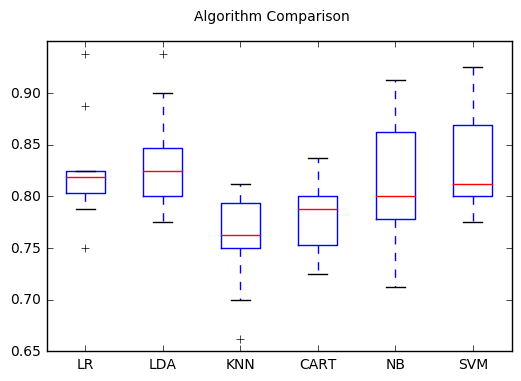

In [34]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 5. Make predictions on validation dataset

Linear Discriminant Analysis is just about the most accurate model. Now test the accuracy of the model on the validation dataset.

In [83]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
predictions = lda.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.79
[[95 11]
 [31 63]]
             precision    recall  f1-score   support

          0       0.75      0.90      0.82       106
          1       0.85      0.67      0.75        94

avg / total       0.80      0.79      0.79       200



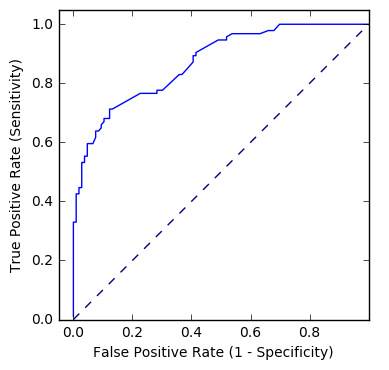

In [91]:
# predict probability of survival
y_pred_prob = lda.predict_proba(X_validation)[:, 1]

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Y_validation, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [89]:
# calculate AUC
print(metrics.roc_auc_score(Y_validation, y_pred_prob))

0.870784825371
